# Лабораторная работа 8

В первой главе данного курса вам было предложено с помощью фреймворка sklearn обучить модель машинного обучения для задачи бинарной классификации на наборе данных Titanic. Давайте попробуем выполнить ту же самую задачу с помощью фреймворка глубокого обучения TensorFlow.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import tensorflow as tf
import tqdm

%matplotlib inline

# Описание набора данных
В данной работе целью исследования будет набор данных Titanic. Данный набор содержит информацию о различных пассажирах корабля "Титаник", затонувшего в ночь на 15-е апреля 1912 года. Некоторое количество пассажиров спаслось, чему способствовало множество различных факторов, включая их пол, возраст, на какой палубе находилась их кабина, социальный статус, и т.д. Мы предлагаем вам натренировать нейронную сеть для бинарной классификации, способную предсказывать вероятность спасения человека на основе его данных.  

Набор данных состоит из различных признаков, описывающих информацию о пассажирах. Каждая строка таблицы - отдельный пассажир, вся информация о нем содержится в его строке. В столбце survived находится бинарная метка (0 или 1), означающая, спасся ли человек с корабля (1) или нет (0). Вашей задачей является изучить набор данных, корректно определить решаемую задачу, а затем построить модель, которая будет способна предсказывать вероятность спасения и посчитать F1-метрику на тестовом наборе данных.

In [2]:
import tensorflow_datasets as tfds
ds, info = tfds.load(
    name='titanic',
    split='train',
    with_info=True
)

In [3]:
df = tfds.as_dataframe(ds, info)

In [4]:
df.head()

,age,boat,body,cabin,embarked,fare,home.dest,name,parch,pclass,sex,sibsp,survived,ticket
0,30.0,b'Unknown',-1,b'Unknown',2,13.0000,"b'Sarnia, ON'","b'McCrie, Mr. James Matthew'",0,1,0,0,0,b'233478'
1,37.0,b'Unknown',98,b'Unknown',2,7.9250,"b'Ruotsinphytaa, Finland New York, NY'","b'Gustafsson, Mr. Anders Vilhelm'",0,2,0,2,0,b'3101276'
2,28.0,b'9',-1,b'Unknown',2,13.0000,b'Spain',"b'Reynaldo, Ms. Encarnacion'",0,1,1,0,1,b'230434'
3,18.0,b'Unknown',-1,b'Unknown',2,73.5000,"b'Lyndhurst, England'","b'Davies, Mr. Charles Henry'",0,1,0,0,0,b'S.O.C. 14879'
4,-1.0,b'Unknown',-1,b'Unknown',0,7.8958,b'Unknown',"b'Gheorgheff, Mr. Stanio'",0,2,0,0,0,b'349254'


# Предобработка данных

Найдем медианный возраст в разбивке по классу обслуживания и полу

In [5]:
df.groupby(['sex', 'pclass'], as_index=False).agg({'age':'median'})

,sex,pclass,age
0,0,0,37.0
1,0,1,28.0
2,0,2,21.0
3,1,0,35.0
4,1,1,27.0
5,1,2,17.0


Действительно существуют различия. Люди постарше могут позволить себе более высокий класс обслуживания

Заменим пропущенные значения в зависимости от пола и класса

In [6]:
for i in df.groupby(['sex', 'pclass'], as_index=False).agg({'age':'median'}).values:
    list_indxs = df[(df.sex == i[0]) & (df.pclass == i[1]) & (df.age == -1)].index
    for indx in list_indxs:
        df.iloc[indx, 0] = i[2]

In [7]:
df.head()

,age,boat,body,cabin,embarked,fare,home.dest,name,parch,pclass,sex,sibsp,survived,ticket
0,30.0,b'Unknown',-1,b'Unknown',2,13.0000,"b'Sarnia, ON'","b'McCrie, Mr. James Matthew'",0,1,0,0,0,b'233478'
1,37.0,b'Unknown',98,b'Unknown',2,7.9250,"b'Ruotsinphytaa, Finland New York, NY'","b'Gustafsson, Mr. Anders Vilhelm'",0,2,0,2,0,b'3101276'
2,28.0,b'9',-1,b'Unknown',2,13.0000,b'Spain',"b'Reynaldo, Ms. Encarnacion'",0,1,1,0,1,b'230434'
3,18.0,b'Unknown',-1,b'Unknown',2,73.5000,"b'Lyndhurst, England'","b'Davies, Mr. Charles Henry'",0,1,0,0,0,b'S.O.C. 14879'
4,21.0,b'Unknown',-1,b'Unknown',0,7.8958,b'Unknown',"b'Gheorgheff, Mr. Stanio'",0,2,0,0,0,b'349254'


Данные о билете, кабине и id пассажира не поддаются систематизации и могут только запутать модель, поэтому сразу их удаляем. 

Данные о статусе в обществе ( `Mr`, `Miss` и т.д.) могут нести полезную информацию, достанем их из имени.

In [8]:
df.name = df.name.apply(lambda x: str(x).split('.')[0].split()[-1])
df.drop(columns=['boat', 'body', 'cabin', 'home.dest', 'ticket'], inplace=True)
df.head()

,age,embarked,fare,name,parch,pclass,sex,sibsp,survived
0,30.0,2,13.0000,Mr,0,1,0,0,0
1,37.0,2,7.9250,Mr,0,2,0,2,0
2,28.0,2,13.0000,Ms,0,1,1,0,1
3,18.0,2,73.5000,Mr,0,1,0,0,0
4,21.0,0,7.8958,Mr,0,2,0,0,0


Информация в имени действительно полезна, среди пассажирова встречаются доктора, начальники и члены команды корабля. Эти факторы явно влияют на выживаемость пассажира.  

In [9]:
df.name.value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Ms            2
Major         2
Mlle          2
Mme           1
Capt          1
Countess      1
Don           1
Lady          1
Jonkheer      1
Dona          1
Sir           1
Name: name, dtype: int64

Заменим более редкие значения классом `Other`

In [10]:
for person in df.name.value_counts().index[-12:]:
    list_indxs = df[df.name == person].index
    for indx in list_indxs:
        df.iloc[indx, 3] = 'Other'

In [11]:
df.name.value_counts()

Mr        757
Miss      260
Mrs       197
Master     61
Other      18
Dr          8
Rev         8
Name: name, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split

train, val_test = train_test_split(df, test_size=0.6, random_state=1337)

In [13]:
val, test = train_test_split(val_test, test_size=0.5, random_state=1337)

In [14]:
X_train = train.drop(columns='survived')
y_train = train.survived.to_numpy().reshape((-1, 1))
X_val = val.drop(columns='survived')
y_val = val.survived.to_numpy().reshape((-1, 1))
X_test = test.drop(columns='survived')
y_test = test.survived.to_numpy().reshape((-1, 1))

Создадим пайплайн для обработки данных.

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('std_scaler', StandardScaler())
])


cat_pipeline = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder())
])

In [16]:
from sklearn.compose import ColumnTransformer

num_attribs = ['age', 'fare', 'parch', 'sibsp']
cat_attribs = ['embarked', 'name', 'pclass', 'sex']

pipeline = ColumnTransformer([("num", num_pipeline, num_attribs), 
                                   ("cat", cat_pipeline, cat_attribs)])

Обучаем пайплайн на тестовых данных

In [17]:
X_train = pipeline.fit_transform(X_train)
X_val = pipeline.transform(X_val)
X_test = pipeline.transform(X_test)

In [18]:
X_train.shape

(523, 20)

# Обучение модели

In [19]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from tensorflow_addons import metrics

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you

Для начала сделам простую модель без скрытых слоев

In [20]:
model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(20,)))
model.add(layers.Dense(1, activation='sigmoid'))

In [21]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
             loss=losses.BinaryCrossentropy(),
             metrics=metrics.FBetaScore(num_classes=2,average="micro",threshold=0.5))

In [22]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    verbose = 0,
                    batch_size= 16,
                    validation_data = (X_val, y_val),
                    callbacks = tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=3
                    )
                   )

Напишем функции, которые будут выводить графики потерь и метрик

In [23]:
def show_loss(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    
    epochs = range(1, len(loss_values) + 1)
    
    plt.plot(epochs, loss_values, 'r', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

In [24]:
def show_f1(history):
    history_dict = history.history
    f1_values = history_dict['fbeta_score']
    val_f1_values = history_dict['val_fbeta_score']
    
    epochs = range(1, len(f1_values) + 1)
    
    plt.plot(epochs, f1_values, 'r', label='Training f1')
    plt.plot(epochs, val_f1_values, 'b', label='Validation f1')
    plt.xlabel('Epochs')
    plt.ylabel('F1')
    plt.legend()
    
    plt.show()

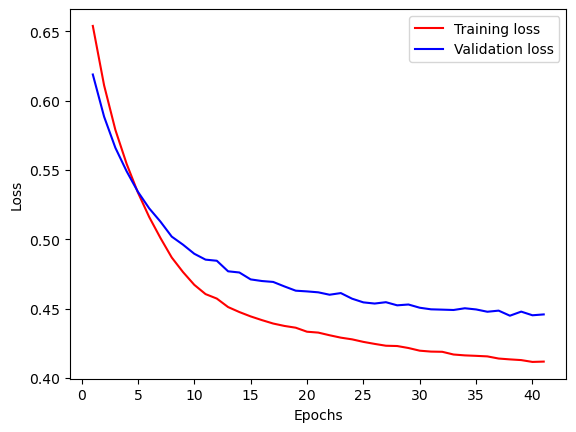

In [25]:
show_loss(history)

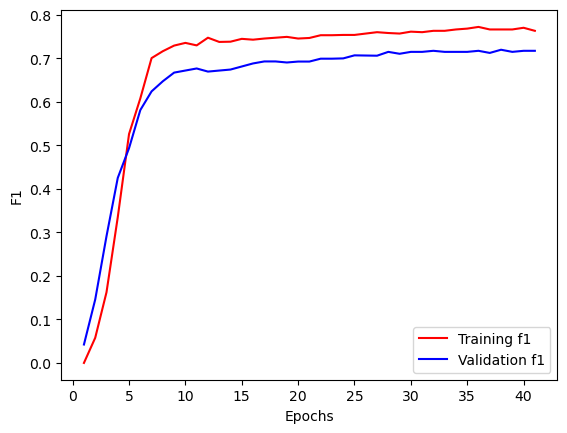

In [26]:
show_f1(history)

In [27]:
history.history['val_fbeta_score'][-1]

0.7167235612869263

Метрика F1 составила 0.71, очень хорошо для простой модели. 

Попробуем усложнить её: добавим пару скрытых слоев и слой Dropout чтобы предотвратить переобучение.

Так как классов не равное количество, то подкорректируем порог для метрики на уровень `threshold=0.6`

In [28]:
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(20,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.4)) 
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [29]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
             loss=losses.BinaryCrossentropy(),
             metrics=metrics.FBetaScore(num_classes=2,average="micro",threshold=0.6))

In [31]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    verbose = 0,
                    batch_size= 16,
                    validation_data = (X_val, y_val),
                    callbacks = tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=3
                    )
                   )

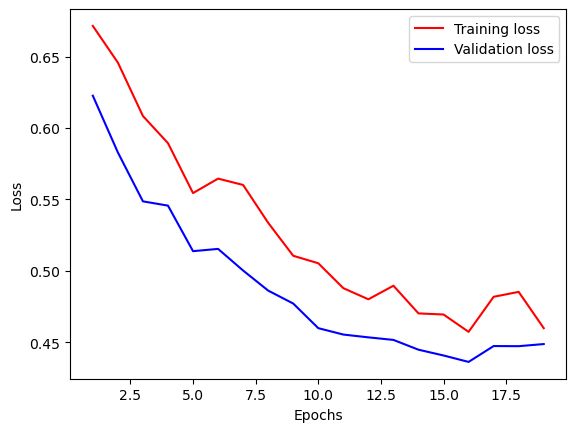

In [32]:
show_loss(history)

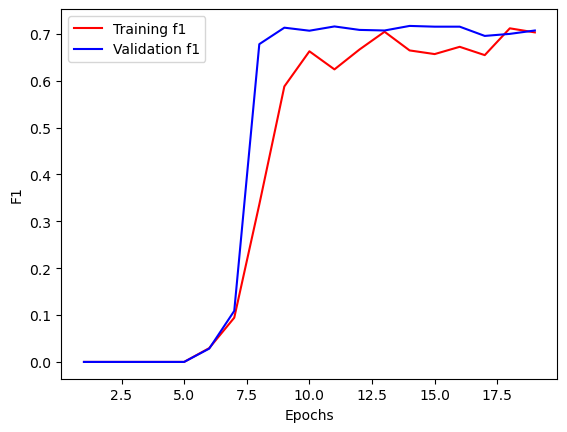

In [33]:
show_f1(history)

In [34]:
history.history['val_fbeta_score'][-1]

0.7072243690490723

Усложнение модели не улучшает метрику. Но так как она менее склонна к переобучению, то будем использовать её.

# Оценка модели

In [35]:
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(20,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.4)) 
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [36]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
             loss=losses.BinaryCrossentropy(),
             metrics=metrics.FBetaScore(num_classes=2,average="micro",threshold=0.6))

In [37]:
history = model.fit(X_train,
                    y_train,
                    epochs=40,
                    verbose = 0,
                    batch_size= 16,
                    validation_data = (X_val, y_val),
                    callbacks = tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=3
                    ))

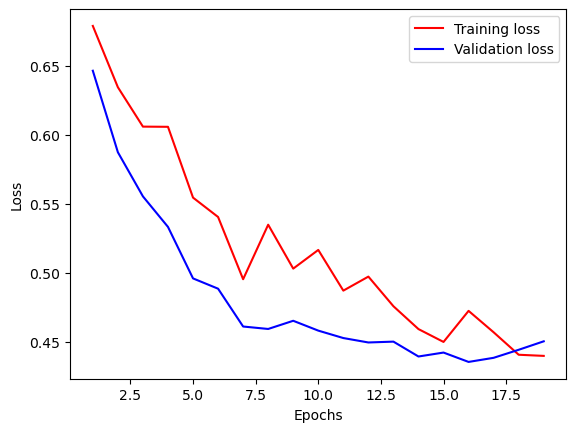

In [38]:
show_loss(history)

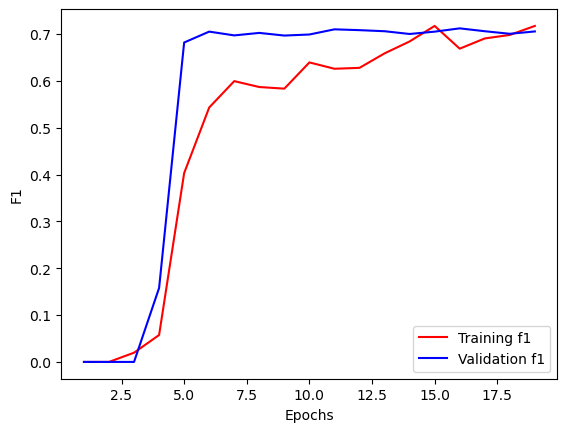

In [39]:
show_f1(history)

Получим метрику для данных, которые модель никогда не видела

In [45]:
metric = metrics.FBetaScore(num_classes=2,average="micro",threshold=0.6)

In [41]:
y_true = y_test
y_pred = model.predict(X_test)

In [46]:
metric.update_state(y_true, y_pred)
result = metric.result()
result.numpy()

0.7759198